Using TensorFlow backend.


(50000, 28, 28) (50000,)


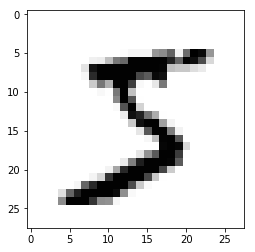

In [1]:
from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
print(X_train.shape, y_train.shape)
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_train[0], cmap="Greys");

In [2]:
import tensorflow as tf
import numpy as np

## Preparation

Relaunch tensorboard, and import useful libraries.

In [2]:
! killall tensorboard
import os
os.system("tensorboard --logdir=/tmp/tboard --port=7007 &");

import tensorflow as tf

import numpy as np

No matching processes belonging to you were found


# Data inspection and preparation

We first take a look at the data, and prepare a version having just two classes.

In [ ]:
X_train.shape

In [3]:
y_train[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

Let's create a flattened version of the data, because tensorflow has difficulty computing gradients across a reshape node.

In [ ]:
with tf.variable_scope("1nn-reshaper"):
    # input shape
    x = tf.placeholder(tf.float32, shape=(None, rows, cols), name="input_X")
    y = tf.placeholder(tf.uint8, shape=(None,), name="input_Y")

    one_hot_y = tf.one_hot(y, 10)
    flat_x = tf.reshape(x, [-1, rows * cols])

X_train_flat, y_train_one_hot = s.run([flat_x, one_hot_y], feed_dict={
    x: X_train,
    y: y_train
})

## Single layer neural network

We first create a simple single layer neural network. We use a one_hot encode layer and a reshape layer to create a flat X. This will prove to be troublesome in the future, but it works for the first version. We use a softmax function to compute the predicted classes.

Also, for debugging, we create the `correct_prediction` and `accuracy` nodes, to avoid having to compute these metrics by hand after running the network.

In [4]:
rows = 28
cols = 28
classes = 10

tf.reset_default_graph()
s = tf.InteractiveSession()

with tf.variable_scope("1nn"):
    weights = tf.get_variable("weights", 
                              [rows * cols, classes],
                              initializer=tf.random_normal_initializer(mean=0, stddev=1e-3),
                              dtype=tf.float32)
    b = tf.get_variable("bias", [classes],
                    initializer=tf.random_uniform_initializer(minval=0, maxval=1e-3),
                    dtype=tf.float32)

    input_X = tf.placeholder(tf.float32, shape=(None, rows, cols), name="input_X")
    input_y = tf.placeholder(tf.uint8, shape=(None,), name="input_Y")

    one_hot_y = tf.one_hot(input_y, classes)
    flat_X = tf.reshape(input_X, [-1, rows * cols])
    
    predicted_y = tf.nn.softmax(tf.matmul(flat_X, weights) + b)
    class_loss = -tf.log(predicted_y) * one_hot_y - tf.log(1 - predicted_y) * (1 - one_hot_y)
    loss = tf.reduce_mean(class_loss)
    
    correct_prediction = tf.equal(tf.cast(input_y, tf.int64), tf.argmax(predicted_y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

Let's test that the weights get correctly initialized.

In [5]:
s.run(tf.global_variables_initializer())
print(s.run([weights, b]))

[array([[  5.79033105e-04,   5.30614925e-04,   3.36251920e-04, ...,
          2.76694028e-03,   1.15641451e-03,  -1.63831748e-03],
       [ -1.58736168e-03,   1.21381214e-04,  -2.19016010e-03, ...,
          1.32015243e-03,   4.94840438e-04,   1.25256577e-03],
       [ -3.99170749e-05,   3.11565556e-04,   6.22138497e-04, ...,
         -6.53253344e-04,   4.62306161e-05,  -8.24748189e-04],
       ..., 
       [  1.43660349e-04,  -8.87794231e-05,   2.98190513e-04, ...,
          2.59238703e-04,   4.58338851e-04,  -1.08343644e-04],
       [  8.14772618e-04,   6.56542543e-04,   1.24888425e-03, ...,
         -9.27994843e-04,  -7.12979992e-04,   1.58063893e-03],
       [  5.21749025e-04,  -1.53792300e-03,   1.33906677e-03, ...,
         -1.45935116e-03,  -2.51419330e-03,   1.67449866e-03]], dtype=float32), array([  2.86260271e-04,   9.36999510e-04,   8.29001729e-05,
         5.16016968e-04,   8.68820585e-04,   6.75416377e-04,
         8.76370585e-04,   2.40242618e-04,   2.61650217e-04,
      

Let's test that the network computes different values correctly, or at least that they seem to be roughly correct. I struggled a bit with different data shapes and wrong initialization. I decided to keep this step to show what pains I went through.

In [7]:
s.run([weights, b, predicted_y, class_loss, one_hot_y, loss, correct_prediction, accuracy],
     {
         input_X: X_train[:3],
         input_y: y_train[:3]
     })

[array([[  5.79033105e-04,   5.30614925e-04,   3.36251920e-04, ...,
           2.76694028e-03,   1.15641451e-03,  -1.63831748e-03],
        [ -1.58736168e-03,   1.21381214e-04,  -2.19016010e-03, ...,
           1.32015243e-03,   4.94840438e-04,   1.25256577e-03],
        [ -3.99170749e-05,   3.11565556e-04,   6.22138497e-04, ...,
          -6.53253344e-04,   4.62306161e-05,  -8.24748189e-04],
        ..., 
        [  1.43660349e-04,  -8.87794231e-05,   2.98190513e-04, ...,
           2.59238703e-04,   4.58338851e-04,  -1.08343644e-04],
        [  8.14772618e-04,   6.56542543e-04,   1.24888425e-03, ...,
          -9.27994843e-04,  -7.12979992e-04,   1.58063893e-03],
        [  5.21749025e-04,  -1.53792300e-03,   1.33906677e-03, ...,
          -1.45935116e-03,  -2.51419330e-03,   1.67449866e-03]], dtype=float32),
 array([  2.86260271e-04,   9.36999510e-04,   8.29001729e-05,
          5.16016968e-04,   8.68820585e-04,   6.75416377e-04,
          8.76370585e-04,   2.40242618e-04,   2.61650

Finally, compute accuracy metrics when training the network.

In [8]:
s.run(tf.global_variables_initializer())

losses = []
test_accuracies = []
train_accuracies = []

for i in range(30):
    s.run(optimizer, {input_X: X_train, input_y: y_train})
    loss_i = s.run(loss,  {input_X: X_train, input_y: y_train})
    losses += [loss_i]
    train_accuracies += [s.run(accuracy, {input_X:X_train, input_y: y_train})]
    test_accuracies += [s.run(accuracy, {input_X:X_test, input_y: y_test})]


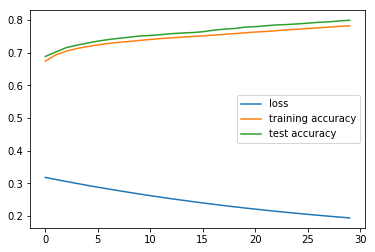

In [9]:
plt.figure()
plt.plot(losses);
plt.plot(train_accuracies)
plt.plot(test_accuracies);
plt.legend(['loss', 'training accuracy', 'test accuracy'])


## Multilayer neural network

In this neural network, we use a second 50 neuron layer. The first layer has a sigmoid activation function.

In [34]:
from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
print(X_train.shape, y_train.shape)

import tensorflow as tf

rows = 28
cols = 28
classes = 10

layer_cnt = 0

def add_layer(in_, size):
    W2 = tf.get_variable("weights{}".format(layer_cnt), 
                              [in_.shape[1], size],
                              initializer=tf.random_normal_initializer(mean=0, stddev=sigma),
                              dtype=tf.float32)
    b2 = tf.get_variable("bias{}".format(layer_cnt), [in_.shape[1]],
                    initializer=tf.zeros_initializer(),
                    dtype=tf.float32)

    y2 = tf.nn.softmax(tf.matmulin_, W2) + b2)
    
    layer_cnt += 1
    return y2

hidden_size = 30

tf.reset_default_graph()
s = tf.InteractiveSession()

with tf.variable_scope("1nn-2layers"):
    # input shape
    input_x = tf.placeholder(tf.float32, shape=(None, rows, cols), name="input_X")
    label_y = tf.placeholder(tf.uint8, shape=(None,), name="input_Y")

    y_ = tf.one_hot(label_y, classes, dtype=tf.float32)
    x = tf.reshape(input_x, [-1, rows * cols])
    
    sigma = np.sqrt(2. / 10.)
    sigma = 0.4
    print("sigma", sigma)
  
    # input layer
    W1 = tf.get_variable("weights", 
                              [rows * cols, hidden_size],
                              initializer=tf.random_normal_initializer(mean=0, stddev=sigma),
                              dtype=tf.float32)
    b1 = tf.get_variable("bias", [hidden_size],
                    initializer=tf.zeros_initializer(),
                    dtype=tf.float32)

    y1 = tf.nn.sigmoid(tf.matmul(x, W1) + b1)

    # hidden layer
    W2 = tf.get_variable("hidden_weights", 
                              [hidden_size, hidden_size],
                              initializer=tf.random_normal_initializer(mean=0, stddev=sigma),
                              dtype=tf.float32)
    b2 = tf.get_variable("hidden_bias", [hidden_size],
                    initializer=tf.zeros_initializer(),
                    dtype=tf.float32)

    y2 = tf.nn.softmax(tf.matmul(y1, W2) + b2)

    # hidden layer
    W3 = tf.get_variable("hidden_weights2", 
                              [hidden_size, classes],
                              initializer=tf.random_normal_initializer(mean=0, stddev=sigma),
                              dtype=tf.float32)
    b3 = tf.get_variable("hidden_bias2", [classes],
                    initializer=tf.zeros_initializer(),
                    dtype=tf.float32)

    y3 = tf.nn.softmax(tf.matmul(y2, W3) + b3)

    # output
    y = y3

    loss = tf.reduce_mean(-tf.reduce_sum(tf.cast(y_, tf.float32) * tf.log(y), 
    reduction_indices=[1]))
    
    correct_prediction = tf.equal(tf.argmax(y_, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    optimizer = tf.train.GradientDescentOptimizer(2.).minimize(loss)
    
    s.run(tf.global_variables_initializer())



IndentationError: unindent does not match any outer indentation level (<tokenize>, line 50)

Next, we create a generator that will provide us with randomized minibatches, to do incremental training.

In [21]:
import random

class MiniBatchGenerator:
    def __init__(self, X, y, batch_size):
        self.X = X.copy()
        self.y = y.copy()
        self.batch_size = batch_size
        self.current_i = 0
        self.total_size = len(self.X)
        
        self.reshuffle()
        
    def reshuffle(self):        
        idxs = list(range(self.total_size))
        random.shuffle(idxs)
        self.X_shuffled = self.X[idxs]
        self.y_shuffled = self.y[idxs]        
        
    def __iter__(self):
        return self
    
    def __next__(self):
        return self.next()
    
    def next(self):
        res_X = []
        res_y = []
        
        end_i = self.current_i + self.batch_size
        
        if end_i > self.total_size:
            rem = end_i - self.total_size
            res_X = self.X_shuffled[self.current_i:]
            res_y = self.y_shuffled[self.current_i:]
            self.reshuffle()
            res_X = np.append(res_X, self.X_shuffled[:rem], axis=0)
            res_y = np.append(res_y, self.y_shuffled[:rem])
            self.current_i = rem
        else:
            res_X = self.X_shuffled[self.current_i:end_i]
            res_y = self.y_shuffled[self.current_i:end_i]
            self.current_i = end_i
        
        return res_X, res_y

In [32]:
s.run(tf.global_variables_initializer())

batcher = MiniBatchGenerator(X_train, y_train, 1000)
print(X_train.shape)
print(y_train.shape)

for i in range(10000):
    X_batch, y_batch = batcher.next()
    
    loss_i, accuracy_i, optimizer_i = s.run([
        loss, accuracy, optimizer
    ],  {input_x: X_batch, 
                     label_y: y_batch})
    if i % 100 == 0:
        print("loss at iter %i:%.4f" % (i, loss_i))
        print("train accuracy:", accuracy_i)
    
    
    if accuracy_i > 0.98:
        accuracy_i = s.run(
            accuracy 
        ,  {input_x: X_train, 
             label_y: y_train})
        print("Total accuracy: {}".format(accuracy_i))

accuracy_i = s.run([
    accuracy
],  {input_x: X_test, 
     label_y: y_test})

print("test_accuracy:", accuracy_i)


(50000, 28, 28)
(50000,)
loss at iter 0:2.3284
train accuracy: 0.063
loss at iter 100:1.3399
train accuracy: 0.421
loss at iter 200:1.1936
train accuracy: 0.502
loss at iter 300:0.9971
train accuracy: 0.583
loss at iter 400:0.9223
train accuracy: 0.618
loss at iter 500:0.8193
train accuracy: 0.682
loss at iter 600:0.7426
train accuracy: 0.729
loss at iter 700:0.9437
train accuracy: 0.594
loss at iter 800:0.7265
train accuracy: 0.701
loss at iter 900:0.6475
train accuracy: 0.8
loss at iter 1000:0.6578
train accuracy: 0.815
loss at iter 1100:0.6384
train accuracy: 0.834
loss at iter 1200:0.4520
train accuracy: 0.894
loss at iter 1300:0.4416
train accuracy: 0.883
loss at iter 1400:0.3321
train accuracy: 0.928
loss at iter 1500:0.3690
train accuracy: 0.916
loss at iter 1600:0.3002
train accuracy: 0.927
loss at iter 1700:0.2532
train accuracy: 0.933
loss at iter 1800:0.6706
train accuracy: 0.761
loss at iter 1900:0.2402
train accuracy: 0.94
loss at iter 2000:0.2027
train accuracy: 0.947
los

KeyboardInterrupt: 

In [33]:
accuracy_i = s.run([
    accuracy
],  {input_x: X_test, 
     label_y: y_test})

print("test_accuracy:", accuracy_i)

test_accuracy: [0.94780004]


In [ ]:
28 * 28 * 100